This notebook uses the output database from https://www.kaggle.com/nickrood/can-star-power-predict-box-office-revenue/output
In that niotebook I made predictions with a linear and random forest regressor model but also want to see how a Light GBM would perform on the data (even though Light GBM is not really recommended on small datasets...)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

df_submission=pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')

df_test=pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
df_submission.head(1), df_test.head(1)


In [ ]:
#insert data with 78 features and target
df_tmdb = pd.read_csv("../input/tmdb-2/tmdb.csv")
df_tmdb.head(5)

In [ ]:
#insert some libraries
import json
import ast
from pprint import pprint
import seaborn as sns 
from scipy.stats import norm,skew
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
pd.set_option('display.max_columns', None)

In [ ]:
#split tmdb into train and test 
df_train= df_tmdb.iloc[0:3000] # first 3000 rows of the tmdb dataframe
df_test=df_tmdb.iloc[3000:7398]

In [ ]:
df_train.shape, df_test.shape

In [ ]:
#split data into features and target. All features are either integer, float or dummy.
features = df_train.select_dtypes(include=['int64', 'float64', 'uint8', 'int8']).columns.tolist()
features.remove('log_revenue')
features_unseen = df_test.select_dtypes(include=['int64', 'float64', 'uint8', 'int8']).columns.tolist()
features_unseen.remove('log_revenue')

X, y = df_train[features], df_train['log_revenue']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


In [ ]:
#import libraries for light gbm and feature importance 
import lightgbm as lgb
import eli5

params = {'num_leaves': 15,
         'min_data_in_leaf': 25,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}



In [12]:
#build mogel 
lgb_model= lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=150)

eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')


Training until validation scores don't improve for 150 rounds.
Early stopping, best iteration is:
[514]	training's rmse: 1.64983	valid_1's rmse: 2.12243


Weight,Feature
0.3648,budget
0.0626,log_budget
0.0536,avg_production_power_total
0.0518,log_popularity
0.0482,popularity
0.0416,release_year
0.0406,avg_crew_power_total
0.0287,crew_len
0.0263,runtime
0.0238,belongs_to_collection


In [14]:
#make predictions 

#Prediction
y_pred=lgb_model.predict(X_test)

In [17]:
#look at rmse and R-Squared 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))


print ("R-Squared is:", metrics.r2_score(y_test, y_pred))
print ("The rmse is:", rmse)

R-Squared is: 0.5334451071823478
The rmse is: 2.1224250557066147


In [18]:
#look at actual and predicted values 
compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
compare.head(5)

,Actual,Predicted
1421,10.679872,11.857469
2349,19.905249,18.043306
2562,20.751436,19.785054
137,15.285865,16.469599
116,17.828061,13.444651


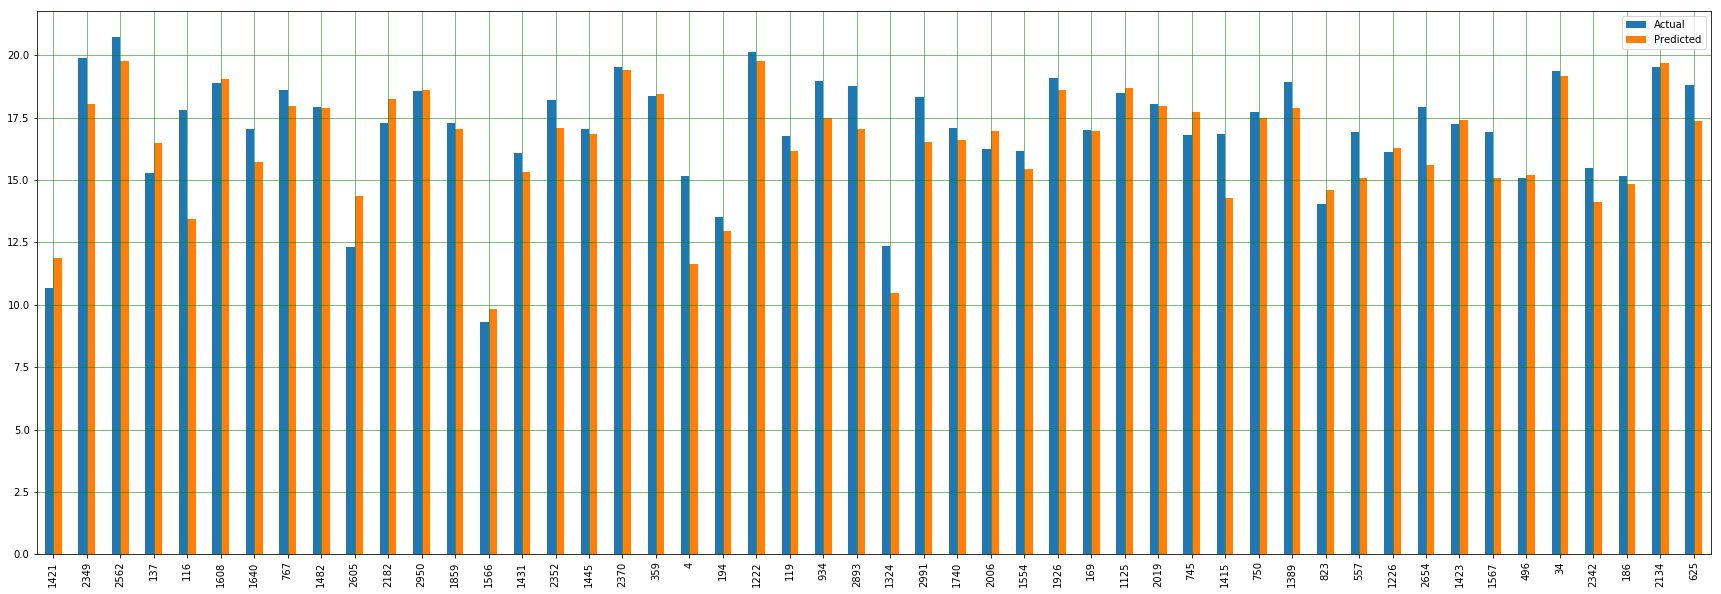

In [21]:
# look at actual and predicted values of first 50 entries in the dataset
compare1 = compare.head(50)
compare1.plot(kind='bar',figsize=(30,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [22]:
#make prediction on unseen test dataset
X_unseen=df_test[features_unseen]
prediction_unseen= lgb_model.predict(X_unseen)

In [23]:
prediction_unseen

array([13.20975848, 13.54448161, 16.28905256, ..., 17.6773145 ,
       14.16304265, 14.15482786])

In [24]:
df_submission['revenue'] = np.expm1(prediction_unseen)


In [25]:
df_submission.head(5)

,id,revenue
0,3001,5.456629e+05
1,3002,7.625934e+05
2,3003,1.186440e+07
3,3004,6.518011e+06
4,3005,3.398445e+05


In [26]:
df_submission[['id','revenue']].to_csv('submission_lgb.csv', index=False)